In [8]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [9]:
import os
import ast

import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from SSMuLA.zs_analysis import (
    ZS_OPTS,
    ZS_COMB_OPTS,
    ZS_OPTS_LEGEND,
)

%matplotlib inline

In [10]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
TOTAL_N_LIST = [n + 96 for n in N_SAMPLE_LIST]

In [11]:
landscape_attribute_df = pd.read_csv("results/merged/merge_landscapeattributes_all.csv")
landscape_attribute_df

,lib,n_site,numb_measured,percent_measured,numb_active,percent_active,active_fit_min,parent_fit,parent_rank,mean,...,top96_SSM_mean_top96,top96_SSM_median_top96,top96_SSM_mean_top384,top96_SSM_median_top384,top96_SSM_fraction_max,top96_SSM_numb_path,numb_loc_opt_norm_cannot_escape,frac_loc_opt_norm_cannot_escape,norm_non-magnitude,norm_reciprocal-sign
0,DHFR,3.0,8000.0,100.000000,854.0,10.675000,0.158614,0.231325,602.0,0.157945,...,1.000000,1.000000,1.000000,1.000000,0.632319,854,1.0,0.000125,4.465397,0.205829
1,ParD2,3.0,7882.0,98.525000,6533.0,82.885055,0.000087,0.973896,12.0,0.228092,...,1.000000,1.000000,1.000000,1.000000,0.722639,6533,1.0,0.000127,28.445324,5.735556
2,ParD3,3.0,7882.0,98.525000,7248.0,91.956356,0.000485,0.982799,7.0,0.321921,...,1.000000,1.000000,1.000000,1.000000,0.178532,7248,1.0,0.000127,28.665219,5.172631
3,GB1,4.0,149361.0,93.350625,34545.0,23.128528,0.001141,0.114130,3644.0,0.009189,...,1.000000,1.000000,1.000000,1.000000,0.025040,34545,2.0,0.000013,9.278868,1.678579
4,T7,3.0,6725.0,84.062500,234.0,3.479554,0.176534,0.288006,163.0,0.016500,...,0.817149,0.772854,0.817149,0.772854,0.017094,234,4.0,0.000595,1.809783,0.547083
5,TEV,4.0,159132.0,99.457500,18262.0,11.476007,0.035601,0.295036,665.0,-0.012509,...,0.943851,1.000000,0.829413,0.810121,0.003395,18262,23.0,0.000145,6.438395,2.381029
6,TrpB3A,3.0,7971.0,99.637500,59.0,0.740183,0.097444,1.000000,1.0,-0.039231,...,0.428916,0.230815,0.428916,0.230815,0.288136,59,3.0,0.000376,0.446493,0.164719
7,TrpB3B,3.0,7996.0,99.950000,18.0,0.225113,0.086085,1.000000,1.0,-0.055223,...,0.274086,0.127970,0.274086,0.127970,0.166667,18,3.0,0.000375,0.122204,0.057886
8,TrpB3C,3.0,7994.0,99.925000,35.0,0.437828,0.207105,1.000000,1.0,-0.073327,...,0.379468,0.315253,0.379468,0.315253,0.114286,35,4.0,0.000500,0.259397,0.101303
9,TrpB3D,3.0,7763.0,97.037500,719.0,9.261883,0.078985,0.820029,10.0,0.018834,...,1.000000,1.000000,0.996377,1.000000,0.393602,719,3.0,0.000386,4.588191,1.260749


In [12]:
alde_all = pd.read_csv("/disk2/fli/SSMuLA/results/alde/alde_all.csv")
alde_all

,n_mut_cutoff,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
0,all,NaN,1,120,DHFR,onehot,Boosting Ensemble,GREEDY,120,0.859808,0.024965,0.02
1,all,NaN,1,120,DHFR,onehot,Boosting Ensemble,TS,120,0.865163,0.022834,0.00
2,all,NaN,1,120,DHFR,onehot,Boosting Ensemble,UCB,120,0.842993,0.027852,0.02
3,all,NaN,1,120,DHFR,onehot,DKL,GREEDY,120,0.758989,0.023827,0.02
4,all,NaN,1,120,DHFR,onehot,DKL,TS,120,0.789997,0.021010,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
27285,double,ds-Triad,4,480,TrpB3I,onehot,DNN Ensemble,GREEDY,480,1.000000,0.000000,1.00
27286,double,ds-Triad,4,480,TrpB3I,Random,Random,GREEDY,480,0.985766,0.003312,0.06
27287,double,ds-Triad,4,480,TrpB4,onehot,Boosting Ensemble,GREEDY,480,0.811557,0.014297,0.18
27288,double,ds-Triad,4,480,TrpB4,onehot,DNN Ensemble,GREEDY,480,0.860523,0.015047,0.30


In [13]:
sliced_alde_4 = alde_all[
    (alde_all["rounds"] == 4)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == 384)
    & (alde_all["n_mut_cutoff"] == "all")
]
sliced_alde_4

,n_mut_cutoff,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
13322,all,esmif,4,384,DHFR,onehot,Boosting Ensemble,GREEDY,384,0.997053,0.001843,0.94
13335,all,esmif,4,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.830043,0.019505,0.28
13348,all,esmif,4,384,ParD2,onehot,Boosting Ensemble,GREEDY,384,1.000000,0.000000,1.00
13361,all,esmif,4,384,ParD3,onehot,Boosting Ensemble,GREEDY,384,0.999546,0.000318,0.96
13374,all,esmif,4,384,T7,onehot,Boosting Ensemble,GREEDY,384,0.775926,0.007815,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
25945,all,NaN,4,384,TrpB3F,onehot,Boosting Ensemble,GREEDY,384,0.949399,0.028288,0.92
25958,all,NaN,4,384,TrpB3G,onehot,Boosting Ensemble,GREEDY,384,0.946825,0.023206,0.88
25971,all,NaN,4,384,TrpB3H,onehot,Boosting Ensemble,GREEDY,384,0.536411,0.063604,0.40
25984,all,NaN,4,384,TrpB3I,onehot,Boosting Ensemble,GREEDY,384,0.994197,0.005434,0.94


In [14]:
ftalde_4 = (
    sliced_alde_4[sliced_alde_4["zs"] != ""][["Protein", "Mean", "Frac"]]
    .groupby("Protein")
    .mean()
    .reset_index()
    .rename(columns={"Protein": "lib", "Mean": "zs_top_max", "Frac": "zs_top_frac"})
)
ftalde_4

,lib,zs_top_max,zs_top_frac
0,DHFR,0.951874,0.657143
1,GB1,0.788081,0.222857
2,ParD2,0.999867,0.985714
3,ParD3,0.997139,0.777143
4,T7,0.782134,0.017143
5,TEV,0.398245,0.005714
6,TrpB3A,0.861855,0.694286
7,TrpB3B,0.400414,0.288571
8,TrpB3C,0.511703,0.257143
9,TrpB3D,0.977501,0.788571


In [15]:
alde_4 = (
    sliced_alde_4[sliced_alde_4["zs"].isna()][["Protein", "Mean", "Frac"]]
    .groupby("Protein")
    .mean()
    .reset_index()
    .rename(columns={"Protein": "lib", "Mean": "top_max", "Frac": "frac"})
)
alde_4

,lib,top_max,frac
0,DHFR,0.934166,0.48
1,GB1,0.768671,0.08
2,ParD2,0.999476,0.94
3,ParD3,0.996783,0.74
4,T7,0.810759,0.00
5,TEV,0.433022,0.04
6,TrpB3A,0.647764,0.50
7,TrpB3B,0.235764,0.12
8,TrpB3C,0.364851,0.04
9,TrpB3D,0.963345,0.62


In [71]:
def slice_alde_ftalde(n: int, alde_all: pd.DataFrame) -> pd.DataFrame:
    sliced_alde = alde_all[
        (alde_all["rounds"] == n)
        & (alde_all["Encoding"] == "onehot")
        & (alde_all["Model"] == "Boosting Ensemble")
        & (alde_all["Acquisition"] == "GREEDY")
        & (alde_all["n_samples"] == 384)
        & (alde_all["n_mut_cutoff"] == "all")
    ]

    ftalde = (
        sliced_alde[sliced_alde["zs"] != ""][["Protein", "Mean", "Frac"]]
        .groupby("Protein")
        .mean()
        .reset_index()
        .rename(columns={"Protein": "lib", "Mean": f"zs_top_max_{n}", "Frac": f"zs_frac_{n}"})
    )

    alde = (
        sliced_alde[sliced_alde["zs"].isna()][["Protein", "Mean", "Frac"]]
        .groupby("Protein")
        .mean()
        .reset_index()
        .rename(columns={"Protein": "lib", "Mean": f"top_max_{n}", "Frac": f"frac_{n}"})
    )
    return pd.merge(alde, ftalde, on="lib")

In [72]:
slice_alde_ftalde(n=4, alde_all=alde_all)

,lib,top_max_4,frac_4,zs_top_max_4,zs_frac_4
0,DHFR,0.934166,0.48,0.951874,0.657143
1,GB1,0.768671,0.08,0.788081,0.222857
2,ParD2,0.999476,0.94,0.999867,0.985714
3,ParD3,0.996783,0.74,0.997139,0.777143
4,T7,0.810759,0.00,0.782134,0.017143
5,TEV,0.433022,0.04,0.398245,0.005714
6,TrpB3A,0.647764,0.50,0.861855,0.694286
7,TrpB3B,0.235764,0.12,0.400414,0.288571
8,TrpB3C,0.364851,0.04,0.511703,0.257143
9,TrpB3D,0.963345,0.62,0.977501,0.788571


In [73]:
alde_n = pd.merge(
    pd.merge(
        pd.merge(
            landscape_attribute_df, slice_alde_ftalde(n=4, alde_all=alde_all), on="lib"
        ),
        slice_alde_ftalde(n=3, alde_all=alde_all),
        on="lib",
    ),
    slice_alde_ftalde(n=2, alde_all=alde_all),
    on="lib",
)
alde_n

,lib,n_site,numb_measured,percent_measured,numb_active,percent_active,active_fit_min,parent_fit,parent_rank,mean,...,zs_top_max_4,zs_frac_4,top_max_3,frac_3,zs_top_max_3,zs_frac_3,top_max_2,frac_2,zs_top_max_2,zs_frac_2
0,DHFR,3.0,8000.0,100.000000,854.0,10.675000,0.158614,0.231325,602.0,0.157945,...,0.951874,0.657143,0.941761,0.44,0.957897,0.660000,0.923070,0.28,0.951953,0.602857
1,ParD2,3.0,7882.0,98.525000,6533.0,82.885055,0.000087,0.973896,12.0,0.228092,...,0.999867,0.985714,0.999592,0.96,0.999884,0.988571,0.998952,0.90,0.999825,0.982857
2,ParD3,3.0,7882.0,98.525000,7248.0,91.956356,0.000485,0.982799,7.0,0.321921,...,0.997139,0.777143,0.997198,0.76,0.995704,0.671429,0.996743,0.72,0.994806,0.608571
3,GB1,4.0,149361.0,93.350625,34545.0,23.128528,0.001141,0.114130,3644.0,0.009189,...,0.788081,0.222857,0.716543,0.02,0.780508,0.177143,0.663641,0.04,0.726893,0.100000
4,T7,3.0,6725.0,84.062500,234.0,3.479554,0.176534,0.288006,163.0,0.016500,...,0.782134,0.017143,0.812709,0.06,0.786429,0.037143,0.772926,0.02,0.772467,0.042857
5,TEV,4.0,159132.0,99.457500,18262.0,11.476007,0.035601,0.295036,665.0,-0.012509,...,0.398245,0.005714,0.420907,0.02,0.402798,0.002857,0.391253,0.02,0.383837,0.002857
6,TrpB3A,3.0,7971.0,99.637500,59.0,0.740183,0.097444,1.000000,1.0,-0.039231,...,0.861855,0.694286,0.642188,0.46,0.808923,0.645714,0.523869,0.24,0.739347,0.502857
7,TrpB3B,3.0,7996.0,99.950000,18.0,0.225113,0.086085,1.000000,1.0,-0.055223,...,0.400414,0.288571,0.260592,0.14,0.391439,0.254286,0.230716,0.10,0.399824,0.225714
8,TrpB3C,3.0,7994.0,99.925000,35.0,0.437828,0.207105,1.000000,1.0,-0.073327,...,0.511703,0.257143,0.328971,0.00,0.505041,0.240000,0.332430,0.02,0.534849,0.257143
9,TrpB3D,3.0,7763.0,97.037500,719.0,9.261883,0.078985,0.820029,10.0,0.018834,...,0.977501,0.788571,0.959605,0.52,0.966650,0.720000,0.931474,0.30,0.951957,0.602857


In [74]:
active_cutoff = 1
active_lib_list = alde_n[(alde_n["percent_active"]>active_cutoff)]["lib"].tolist() # & (lib_stat["percent_measured"]>90)
active_lib_list

['DHFR',
 'ParD2',
 'ParD3',
 'GB1',
 'T7',
 'TEV',
 'TrpB3D',
 'TrpB3E',
 'TrpB3F',
 'TrpB3G',
 'TrpB3I',
 'TrpB4']

In [75]:
merge_df = alde_n[alde_n["lib"].isin(active_lib_list)].sort_values("lib")
merge_df

,lib,n_site,numb_measured,percent_measured,numb_active,percent_active,active_fit_min,parent_fit,parent_rank,mean,...,zs_top_max_4,zs_frac_4,top_max_3,frac_3,zs_top_max_3,zs_frac_3,top_max_2,frac_2,zs_top_max_2,zs_frac_2
0,DHFR,3.0,8000.0,100.000000,854.0,10.675000,0.158614,0.231325,602.0,0.157945,...,0.951874,0.657143,0.941761,0.44,0.957897,0.660000,0.923070,0.28,0.951953,0.602857
3,GB1,4.0,149361.0,93.350625,34545.0,23.128528,0.001141,0.114130,3644.0,0.009189,...,0.788081,0.222857,0.716543,0.02,0.780508,0.177143,0.663641,0.04,0.726893,0.100000
1,ParD2,3.0,7882.0,98.525000,6533.0,82.885055,0.000087,0.973896,12.0,0.228092,...,0.999867,0.985714,0.999592,0.96,0.999884,0.988571,0.998952,0.90,0.999825,0.982857
2,ParD3,3.0,7882.0,98.525000,7248.0,91.956356,0.000485,0.982799,7.0,0.321921,...,0.997139,0.777143,0.997198,0.76,0.995704,0.671429,0.996743,0.72,0.994806,0.608571
4,T7,3.0,6725.0,84.062500,234.0,3.479554,0.176534,0.288006,163.0,0.016500,...,0.782134,0.017143,0.812709,0.06,0.786429,0.037143,0.772926,0.02,0.772467,0.042857
5,TEV,4.0,159132.0,99.457500,18262.0,11.476007,0.035601,0.295036,665.0,-0.012509,...,0.398245,0.005714,0.420907,0.02,0.402798,0.002857,0.391253,0.02,0.383837,0.002857
9,TrpB3D,3.0,7763.0,97.037500,719.0,9.261883,0.078985,0.820029,10.0,0.018834,...,0.977501,0.788571,0.959605,0.52,0.966650,0.720000,0.931474,0.30,0.951957,0.602857
10,TrpB3E,3.0,7964.0,99.550000,161.0,2.021597,0.041910,0.610622,5.0,0.002082,...,0.827857,0.780000,0.552314,0.38,0.828370,0.731429,0.400294,0.14,0.793881,0.617143
11,TrpB3F,3.0,7737.0,96.712500,82.0,1.059842,0.092374,1.000000,1.0,-0.023140,...,0.992771,0.988571,0.967708,0.96,0.992177,0.982857,0.956830,0.82,0.968045,0.911429
12,TrpB3G,3.0,7891.0,98.637500,108.0,1.368648,0.072712,0.519956,13.0,-0.002391,...,0.983703,0.945714,0.871218,0.78,0.961381,0.905714,0.823322,0.46,0.942824,0.808571


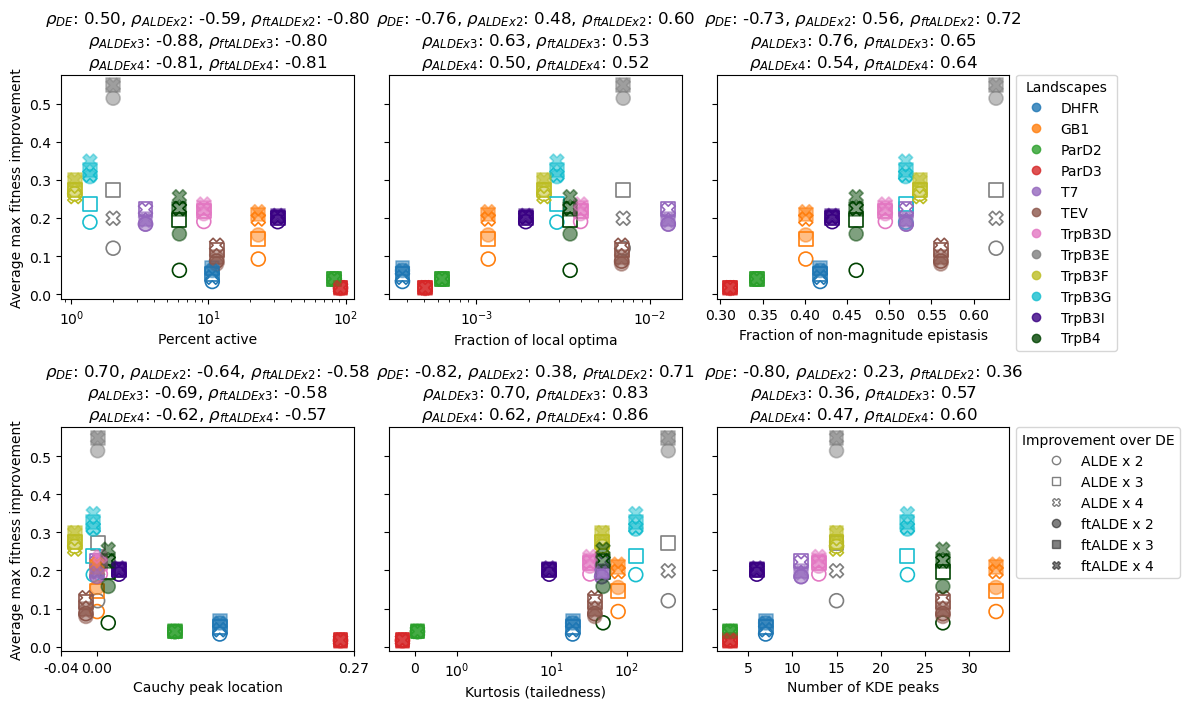

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import spearmanr

import colorcet as cc
import matplotlib.colors as mcolors

# Select a colorcet colormap, for example, 'fire' or 'CET_CBL1'
colormap = cc.cm['glasbey_category10']

# Extract a list of hex codes from the colormap
glasbey_category10 = [mcolors.to_hex(colormap(i)) for i in range(colormap.N)]

# Define a reusable function for scatter plots and titles
def create_scatter(
    ax, x_data, y_data, xlabel, title_fmt, x_scale="linear", y_label=None
):
    for y, label in zip(
        [alde_2, alde_3, alde_4, ftalde_2, ftalde_3, ftalde_4], ["ALDE x 2", "ALDE x 3", "ALDE x 4", "ftALDE x 2", "ftALDE x 3", "ftALDE x 4"]
    ):
        ax.scatter(
            x_data, y, edgecolors=clist, s=100, linewidth=1.2, **style_dict[label]
        )

    ax.set_xscale(x_scale)
    ax.set_xlabel(xlabel)
    if y_label:
        ax.set_ylabel(y_label)
    # Title with two lines including both MLDE/ftMLDE and ALDE/ftALDE correlations
    ax.set_title(
        (
            title_fmt.format(
                spearmanr(merge_df["single_step_DE_mean_all"], x_data)[0],
                spearmanr(alde_2, x_data)[0],
                spearmanr(ftalde_2, x_data)[0],
            )
            + "\n"
            + r"$\rho_{{ALDE x 3}}$: {:.2f}, $\rho_{{ftALDE x 3}}$: {:.2f}".format(
                spearmanr(alde_3, x_data)[0], spearmanr(ftalde_3, x_data)[0]
            )
            + "\n"
            + r"$\rho_{{ALDE x 4}}$: {:.2f}, $\rho_{{ftALDE x 4}}$: {:.2f}".format(
                spearmanr(alde_4, x_data)[0], spearmanr(ftalde_4, x_data)[0]
            )
        )
    )


# Prepare data
alde_2 = merge_df["top_max_2"] - merge_df["single_step_DE_mean_all"]
alde_3 = merge_df["top_max_3"] - merge_df["single_step_DE_mean_all"]
alde_4 = merge_df["top_max_4"] - merge_df["single_step_DE_mean_all"]
ftalde_2 = merge_df["zs_top_max_2"] - merge_df["single_step_DE_mean_all"]
ftalde_3 = merge_df["zs_top_max_3"] - merge_df["single_step_DE_mean_all"]
ftalde_4 = merge_df["zs_top_max_4"] - merge_df["single_step_DE_mean_all"]

clist = glasbey_category10[:12] # sns.color_palette("tab10").as_hex() + ["#e5c494", "#a6cee3"]

# Updated style dictionary
style_dict = {
    "ALDE x 2": {"facecolors": "none", "marker": "o"},
    "ALDE x 3": {"facecolors": "none", "marker": "s"},
    "ALDE x 4": {"facecolors": "none", "marker": "X"},
    "ftALDE x 2": {"facecolors": clist, "marker": "o", "alpha": 0.5},
    "ftALDE x 3": {"facecolors": clist, "marker": "s", "alpha": 0.5},
    "ftALDE x 4": {"facecolors": clist, "marker": "X", "alpha": 0.5},
}

# Create figure and axes
fig, ax = plt.subplots(2, 3, figsize=(12, 7.2), sharey=True)

# Scatter plots
create_scatter(
    ax[0, 0],
    merge_df["percent_active"],
    [alde_2, alde_3, alde_4, ftalde_2, ftalde_3, ftalde_4],
    "Percent active",
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE x 2}}$: {:.2f}, $\rho_{{ftALDE x 2}}$: {:.2f}",
    x_scale="log",
    y_label="Average max fitness improvement",
)

create_scatter(
    ax[0, 1],
    merge_df["frac_loc_opt_total"],
    [alde_2, alde_3, alde_4, ftalde_2, ftalde_3, ftalde_4],
    "Fraction of local optima",
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE x 2}}$: {:.2f}, $\rho_{{ftALDE x 2}}$: {:.2f}",
    x_scale="log",
)

create_scatter(
    ax[0, 2],
    merge_df["fraction_non-magnitude"],
    [alde_2, alde_3, alde_4, ftalde_2, ftalde_3, ftalde_4],
    "Fraction of non-magnitude epistasis",
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE x 2}}$: {:.2f}, $\rho_{{ftALDE x 2}}$: {:.2f}",
)

create_scatter(
    ax[1, 0],
    merge_df["loc"],
    [alde_2, alde_3, alde_4, ftalde_2, ftalde_3, ftalde_4],
    "Cauchy peak location",
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE x 2}}$: {:.2f}, $\rho_{{ftALDE x 2}}$: {:.2f}",
    x_scale="symlog",
    y_label="Average max fitness improvement",
)
ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.2f"))

create_scatter(
    ax[1, 1],
    merge_df["kurt"],
    [alde_2, alde_3, alde_4, ftalde_2, ftalde_3, ftalde_4],
    "Kurtosis (tailedness)",
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE x 2}}$: {:.2f}, $\rho_{{ftALDE x 2}}$: {:.2f}",
    x_scale="symlog",
)

create_scatter(
    ax[1, 2],
    merge_df["numb_kde_peak"],
    [alde_2, alde_3, alde_4, ftalde_2, ftalde_3, ftalde_4],
    "Number of KDE peaks",
    r"$\rho_{{DE}}$: {:.2f}, $\rho_{{ALDE x 2}}$: {:.2f}, $\rho_{{ftALDE x 2}}$: {:.2f}",
)

# Legends
legend_list = [
    Line2D([0], [0], marker="o", linestyle="none", color=lc, label=l, alpha=0.8)
    for l, lc in zip(merge_df["lib"], clist)
]
ax[0, 2].legend(
    handles=legend_list,
    loc="upper left",
    title="Landscapes",
    bbox_to_anchor=(1, 1.0325),
)

# Updated legend_list2 using new style_dict
legend_list2 = [
    Line2D(
        [0],
        [0],
        linestyle="none",
        marker=style_dict[label]["marker"],
        markerfacecolor=(
            "black" if style_dict[label]["facecolors"] != "none" else "none"
        ),
        markeredgecolor="black",
        alpha=0.5,
        label=label,
    )
    for label in ["ALDE x 2", "ALDE x 3", "ALDE x 4", "ftALDE x 2", "ftALDE x 3", "ftALDE x 4"]
]
ax[1, 2].legend(
    handles=legend_list2,
    loc="upper left",
    title="Improvement over DE",
    bbox_to_anchor=(1, 1.0315),
)

plt.tight_layout()
plt.show()

In [77]:
merge_mldedf = pd.read_csv("/disk2/fli/SSMuLA/results/corr_3_all/384/boosting|ridge-top96/actcut-1/merge_all_0.125.csv")
merge_mldedf = merge_mldedf.sort_values("lib")
merge_mldedf

,lib,n_site,numb_measured,percent_measured,numb_active,percent_active,active_fit_min,parent_fit,parent_rank,mean,...,if_truemaxs_two-best,deltafrac_double_mlde,deltafrac_ft_mlde,deltafrac_ft_recomb_SSM,deltafrac_ft_single_step_DE,deltafrac_ft_top96_SSM,deltafrac_ft-comb_mlde,deltafrac_ft-comb_recomb_SSM,deltafrac_ft-comb_single_step_DE,deltafrac_ft-comb_top96_SSM
0,DHFR,3.0,8000.0,100.000000,854.0,10.675000,0.158614,0.231325,602.0,0.157945,...,NaN,0.275,0.490,0.909836,0.716432,0.367681,0.490,0.909836,0.716432,0.367681
3,GB1,4.0,149361.0,93.350625,34545.0,23.128528,0.001141,0.114130,3644.0,0.009189,...,NaN,0.000,0.300,0.357945,0.333955,0.334960,0.320,0.377945,0.353955,0.354960
1,ParD2,3.0,7882.0,98.525000,6533.0,82.885055,0.000087,0.973896,12.0,0.228092,...,NaN,-0.020,0.010,0.714832,0.439461,0.277361,0.010,0.714832,0.439461,0.277361
2,ParD3,3.0,7882.0,98.525000,7248.0,91.956356,0.000485,0.982799,7.0,0.321921,...,NaN,-0.170,0.810,0.972136,0.697117,0.801468,0.810,0.972136,0.697117,0.801468
4,T7,3.0,6725.0,84.062500,234.0,3.479554,0.176534,0.288006,163.0,0.016500,...,NaN,-0.050,0.170,0.211453,0.209316,0.202906,0.170,0.211453,0.209316,0.202906
5,TEV,4.0,159132.0,99.457500,18262.0,11.476007,0.035601,0.295036,665.0,-0.012509,...,NaN,0.000,0.000,-0.001040,-0.001964,-0.003395,0.000,-0.001040,-0.001964,-0.003395
6,TrpB3D,3.0,7763.0,97.037500,719.0,9.261883,0.078985,0.820029,10.0,0.018834,...,NaN,0.305,0.445,0.867976,0.755088,0.531398,0.445,0.867976,0.755088,0.531398
7,TrpB3E,3.0,7964.0,99.550000,161.0,2.021597,0.041910,0.610622,5.0,0.002082,...,NaN,0.550,0.550,0.832298,0.795031,0.770186,0.550,0.832298,0.795031,0.770186
8,TrpB3F,3.0,7737.0,96.712500,82.0,1.059842,0.092374,1.000000,1.0,-0.023140,...,NaN,0.085,0.090,0.585366,0.453252,0.256098,0.090,0.585366,0.453252,0.256098
9,TrpB3G,3.0,7891.0,98.637500,108.0,1.368648,0.072712,0.519956,13.0,-0.002391,...,NaN,0.185,0.270,0.786296,0.647407,0.490000,0.270,0.786296,0.647407,0.490000


In [78]:
[c for c in merge_mldedf.columns if "if_truemaxs" in c]

['if_truemaxs',
 'if_truemaxs_Triad-esm',
 'if_truemaxs_Triad-ev',
 'if_truemaxs_Triad',
 'if_truemaxs_esm',
 'if_truemaxs_esmif',
 'if_truemaxs_ev',
 'if_truemaxs_msa-comb',
 'if_truemaxs_msanoif-comb',
 'if_truemaxs_struc-comb',
 'if_truemaxs_structnmsa-comb',
 'if_truemaxs_coves',
 'if_truemaxs_double',
 'if_truemaxs_two-best']

In [79]:
for m in ["top_maxes", "if_truemaxs"]:

    merge_mldedf[f"{m}_pooled_ft"] = merge_mldedf[
        [
            f"{m}_Triad",
            f"{m}_esm",
            f"{m}_esmif",
            f"{m}_ev",
            f"{m}_coves",
            f"{m}_double",
        ]
    ].mean(axis=1, skipna=True)


In [80]:
merge_df = pd.merge(merge_df, merge_mldedf[["lib", "top_maxes", "top_maxes_pooled_ft", "if_truemaxs", "if_truemaxs_pooled_ft"]], on="lib")

In [81]:
alde_n_df = merge_df[
    [
        "lib",
        "single_step_DE_mean_all",
        "single_step_DE_fraction_max",
        "top_maxes",
        "top_max_2",
        "top_max_3",
        "top_max_4",
        "top_maxes_pooled_ft",
        "zs_top_max_2",
        "zs_top_max_3",
        "zs_top_max_4",
        "if_truemaxs",
        "frac_2",
        "frac_3",
        "frac_4",
        "if_truemaxs_pooled_ft",
        "zs_frac_2",
        "zs_frac_3",
        "zs_frac_4",
    ]
].reset_index(drop=True).copy()
alde_n_df

,lib,single_step_DE_mean_all,single_step_DE_fraction_max,top_maxes,top_max_2,top_max_3,top_max_4,top_maxes_pooled_ft,zs_top_max_2,zs_top_max_3,zs_top_max_4,if_truemaxs,frac_2,frac_3,frac_4,if_truemaxs_pooled_ft,zs_frac_2,zs_frac_3,zs_frac_4
0,DHFR,0.889922,0.283568,0.951323,0.923070,0.941761,0.934166,0.958553,0.951953,0.957897,0.951874,0.51,0.28,0.44,0.48,0.669167,0.602857,0.660000,0.657143
1,GB1,0.571523,0.026045,0.677287,0.663641,0.716543,0.768671,0.794627,0.726893,0.780508,0.788081,0.06,0.04,0.02,0.08,0.201667,0.100000,0.177143,0.222857
2,ParD2,0.959795,0.560539,0.999913,0.998952,0.999592,0.999476,0.999764,0.999825,0.999884,0.999867,0.99,0.90,0.96,0.94,0.995000,0.982857,0.988571,0.985714
3,ParD3,0.979911,0.282883,0.990071,0.996743,0.997198,0.996783,0.990138,0.994806,0.995704,0.997139,0.17,0.72,0.76,0.74,0.450833,0.608571,0.671429,0.777143
4,T7,0.589044,0.010684,0.814857,0.772926,0.812709,0.810759,0.765171,0.772467,0.786429,0.782134,0.05,0.02,0.06,0.00,0.038333,0.042857,0.037143,0.017143
5,TEV,0.304653,0.001964,0.403045,0.391253,0.420907,0.433022,0.376078,0.383837,0.402798,0.398245,0.00,0.02,0.02,0.04,0.000000,0.002857,0.002857,0.005714
6,TrpB3D,0.740853,0.169912,0.939406,0.931474,0.959605,0.963345,0.986124,0.951957,0.966650,0.977501,0.48,0.30,0.52,0.62,0.844167,0.602857,0.720000,0.788571
7,TrpB3E,0.279738,0.204969,0.601610,0.400294,0.552314,0.478813,0.964911,0.793881,0.828370,0.827857,0.45,0.14,0.38,0.42,0.921667,0.617143,0.731429,0.780000
8,TrpB3F,0.693419,0.546748,0.980315,0.956830,0.967708,0.949399,0.999515,0.968045,0.992177,0.992771,0.91,0.82,0.96,0.92,0.999167,0.911429,0.982857,0.988571
9,TrpB3G,0.634426,0.342593,0.920440,0.823322,0.871218,0.946825,0.990402,0.942824,0.961381,0.983703,0.72,0.46,0.78,0.88,0.958333,0.808571,0.905714,0.945714


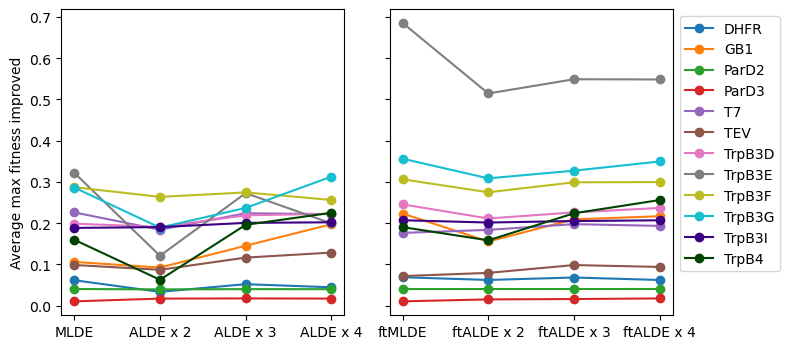

In [82]:
# Set x values (2, 3, 4)
# x = ["DE: Single step", "ALDE x 2", "ALDE x 3", "ALDE x 4"]
x = ["MLDE", "ALDE x 2", "ALDE x 3", "ALDE x 4"]
y_labels = [
    "Average max fitness improved",
    "Fraction reaching the global optimum improved",
]
colors = glasbey_category10[:12]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.6), sharey=True)

# Plot for top_max
for i, row in alde_n_df.iterrows():
    ax1.plot(
        x,
        # [row["single_step_DE_fraction_max"], row["top_max_2"], row["top_max_3"], row["top_max_4"]],
        [
            row["top_maxes"] - row["single_step_DE_mean_all"],
            row["top_max_2"] - row["single_step_DE_mean_all"],
            row["top_max_3"] - row["single_step_DE_mean_all"],
            row["top_max_4"] - row["single_step_DE_mean_all"],
        ],
        label=row["lib"],
        marker="o",
        color=colors[i],
    )

# ax1.set_title(y_labels[0])
# ax1.set_xlabel("X")
ax1.set_ylabel(y_labels[0])
# ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax1.grid(True)

# Plot for zs_top_max
for i, row in alde_n_df.iterrows():
    ax2.plot(
        ["ft"+ftx for ftx in x],
        # [row["single_step_DE_fraction_max"], row["zs_top_max_2"], row["zs_top_max_3"], row["zs_top_max_4"]],
        [
            row["top_maxes_pooled_ft"] - row["single_step_DE_mean_all"],
            row["zs_top_max_2"] - row["single_step_DE_mean_all"],
            row["zs_top_max_3"] - row["single_step_DE_mean_all"],
            row["zs_top_max_4"] - row["single_step_DE_mean_all"],
        ],
        label=row["lib"],
        marker="o",
        color=colors[i],
    )

ax2.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

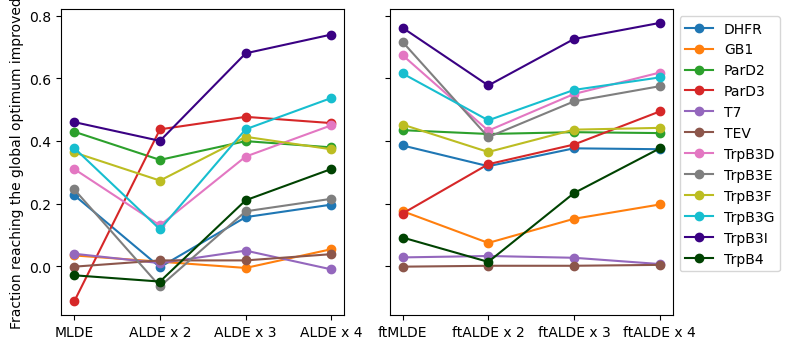

In [83]:
# Set x values (2, 3, 4)
# x = ["DE: Single step", "ALDE x 2", "ALDE x 3", "ALDE x 4"]
x = ["MLDE", "ALDE x 2", "ALDE x 3", "ALDE x 4"]
y_labels = [
    "Average max fitness improved",
    "Fraction reaching the global optimum improved",
]
colors = glasbey_category10[:12]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.6), sharey=True)

# Plot for top_max
for i, row in alde_n_df.iterrows():
    ax1.plot(
        x,
        # [row["single_step_DE_fraction_max"], row["top_max_2"], row["top_max_3"], row["top_max_4"]],
        [
            row["if_truemaxs"] - row["single_step_DE_fraction_max"],
            row["frac_2"] - row["single_step_DE_fraction_max"],
            row["frac_3"] - row["single_step_DE_fraction_max"],
            row["frac_4"] - row["single_step_DE_fraction_max"],
        ],
        label=row["lib"],
        marker="o",
        color=colors[i],
    )

# ax1.set_title(y_labels[0])
# ax1.set_xlabel("X")
ax1.set_ylabel(y_labels[1])
# ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax1.grid(True)

# Plot for zs_top_max
for i, row in alde_n_df.iterrows():
    ax2.plot(
        ["ft"+ftx for ftx in x],
        # [row["single_step_DE_fraction_max"], row["zs_top_max_2"], row["zs_top_max_3"], row["zs_top_max_4"]],
        [
            row["if_truemaxs_pooled_ft"] - row["single_step_DE_fraction_max"],
            row["zs_frac_2"] - row["single_step_DE_fraction_max"],
            row["zs_frac_3"] - row["single_step_DE_fraction_max"],
            row["zs_frac_4"] - row["single_step_DE_fraction_max"],
        ],
        label=row["lib"],
        marker="o",
        color=colors[i],
    )

ax2.legend(loc="upper left", bbox_to_anchor=(1, 1))
# ax2.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()